# Titanic Kaggle competition
This is a guided project from my Data Scientist Path at [Dataquest.io](https://www.dataquest.io), where the goal is to create the best model to compete at [Kaggle](https://www.kaggle.com/competitions/titanic/submissions).  
There are two files: train.csv and test.csv. The model created based on 'train.csv' is then going to be used on 'test.csv' and that submission is sent to Kaggle, to receive the score.

In [25]:
# importing libraries and reading data
import pandas as pd
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The goal of this project is to focus on creating the models and data exploration. The processing of the data has been done in an earlier lesson. For that reason, I will import all the functions that were used to process the data (missing values, binning, extracting categories from text, etc). The functions used are below.  

In [26]:
# %load "functions.py"
# Functions that help pre-process the data
def process_missing(df):
    # Handle missing values from "Fare" and "Embarked" columns
    df["Fare"].fillna(train["Fare"].mean(), inplace=True)
    df["Embarked"].fillna("S", inplace=True)
    return df

def process_age(df):
    # Process the Age column into pre-defined 'bins'
    df["Age_categories"] = pd.cut(
        df["Age"].fillna(-0.5),
        [-1,0,5,12,18,35,60,100],
        labels=[
            "Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"
        ]
    )
    return df

def process_fare(df):
    # Process the Fare column into pre-defined 'bins' 
    df["Fare_categories"] = pd.cut(
        df["Fare"], 
        bins=[-1, 7.5, 15, 50, 200],
        labels=["0-7.5", "7.5-15", "15-50", "200+"]
        )
    return df

def process_cabin(df):
    # Process the Cabin column into pre-defined 'bins'
    df["Cabin_type"] = df["Cabin"].str[0].fillna("Unknown")
    df = df.drop('Cabin', axis=1)
    return df

def process_titles(df):
    # Extract and categorize the title from the name column 
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    # Create Dummy Columns (One Hot Encoding) from a single Column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df


In [27]:
# Applying the functions above to the test and train data
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_cabin(df)
    df = process_titles(df)
    df = create_dummies(df,"Age_categories")
    df = create_dummies(df,"Fare_categories")
    df = create_dummies(df,"Cabin_type")
    df = create_dummies(df,"Title")
    df = create_dummies(df,"Sex")
    return df

train = process_df(train)
holdout = process_df(holdout)

## Exploring some of the data
I'm going to start exploring the columns "SibSp" and "Parch", which represent the number of siblings/spouses and parents/children, respectively. 

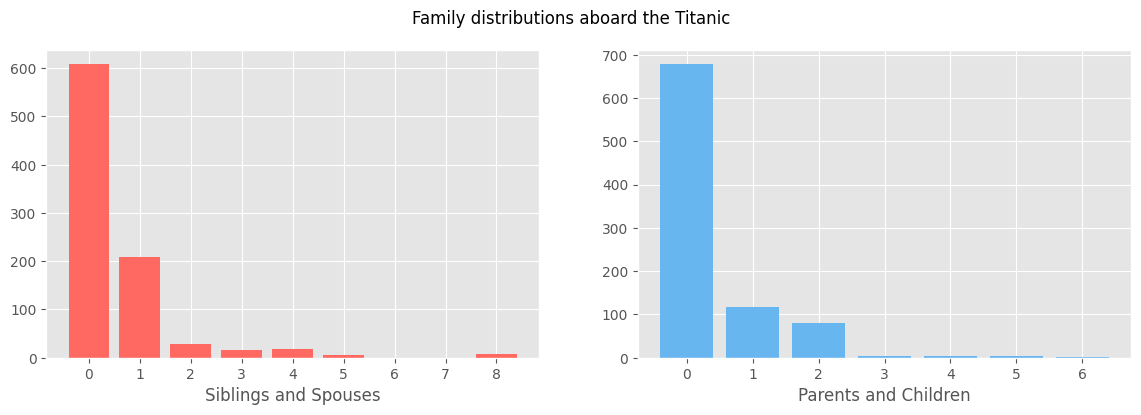

In [28]:
# create a bar chart of these two columns
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

# creating the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Title
fig.suptitle('Family distributions aboard the Titanic')

# Siblings and spouses chart
ax[0].bar(
    train['SibSp'].value_counts().index, 
    train['SibSp'].value_counts(), 
    color='#FF6961'
    )
ax[0].set_xlabel('Siblings and Spouses')

ax[0].set_xticks(range(max(train['SibSp'].value_counts().index)+1))

# Parents and children chart
ax[1].bar(
    train['Parch'].value_counts().index, 
    train['Parch'].value_counts(),
    color='#68b6ef'
    )
ax[1].set_xticks(range(max(train['Parch'].value_counts().index)+1))

ax[1].set_xlabel('Parents and Children')

plt.show()

## Exploring the survival rates according to number of relatives onboard

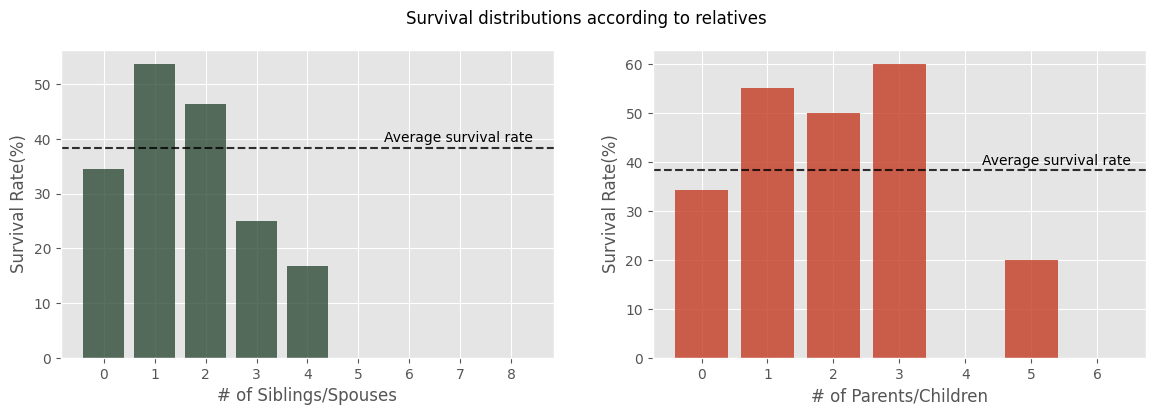

In [29]:
# same plot size as above
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Survival distributions according to relatives')

# Siblings and spouses
ax[0].bar(train[['SibSp', 'Survived']].groupby(['SibSp']).mean().index,
         train[['SibSp', 'Survived']].groupby(['SibSp']).mean()['Survived']*100, 
         color="#2F4C39", alpha=0.8
)

ax[0].set_xlabel('# of Siblings/Spouses')
ax[0].set_ylabel('Survival Rate(%)')
ax[0].set_xticks(range(max(train['SibSp'].value_counts().index)+1))

# average survival rate
ax[0].axhline(
    train['Survived'].mean()*100, 
    color='black', 
    alpha=0.8, 
    linestyle='--',
)
ax[0].text(
    y=train['Survived'].mean()*100+1,
    x=5.5,
    s='Average survival rate'
)

# Parents and children
ax[1].bar(
    train[['Parch', 'Survived']].groupby(['Parch']).mean().index,
    train[['Parch', 'Survived']].groupby(['Parch']).mean()['Survived']*100, 
    color="#c23b22", alpha=0.8
)

ax[1].set_xlabel('# of Parents/Children')
ax[1].set_ylabel('Survival Rate(%)')
ax[1].set_xticks(range(max(train['Parch'].value_counts().index)+1))

# Average survival rate line
ax[1].axhline(
    train['Survived'].mean()*100, 
    color='black', 
    alpha=0.8, 
    linestyle='--',
)
ax[1].text(
    y=train['Survived'].mean()*100+1,
    x=4.25,
    s='Average survival rate'
)
plt.show()

## Looking at family size

In [30]:
# create a function to create the family size column
def create_family_members(df):
    df['family_members'] = df['SibSp'] + df['Parch']
    return df

# apply to both train and holdout
train = create_family_members(train)
holdout = create_family_members(holdout)

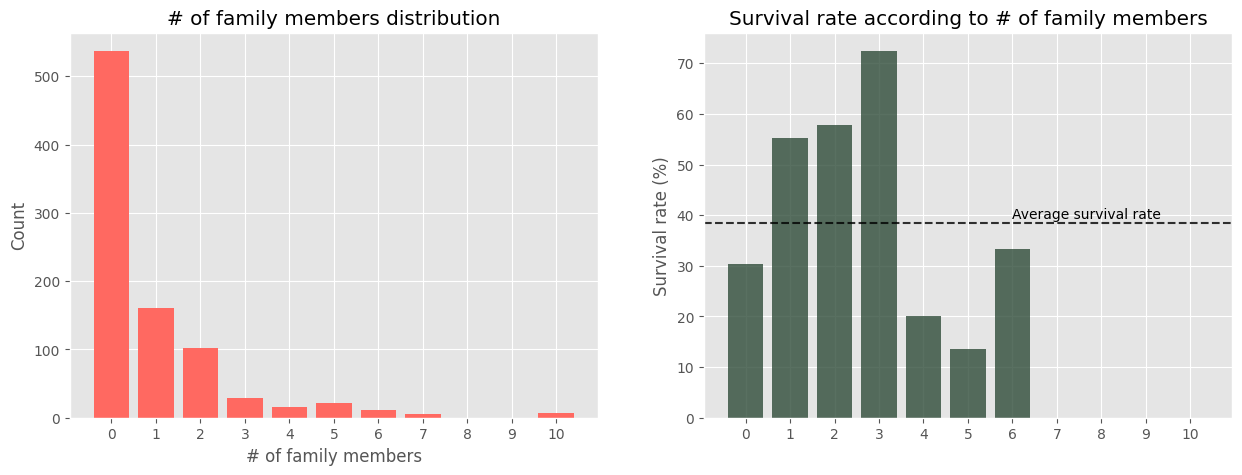

In [31]:
# create the same plots as above but with only the 'family_size' column
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Family size distribution
ax[0].bar(
    train['family_members'].value_counts().index, 
    train['family_members'].value_counts(), 
    color='#FF6961'
    )
ax[0].set_xlabel('# of family members')
ax[0].set_ylabel('Count')
ax[0].set_xticks(range(max(train['family_members'].value_counts().index)+1))
ax[0].set_title('# of family members distribution')

ax[1].bar(
    train[['family_members', 'Survived']].groupby(['family_members']).mean().index,
    train[['family_members', 'Survived']].groupby(['family_members']).mean()['Survived']*100,
    color="#2F4C39", alpha=0.8
)

ax[1].set_xticks(range(max(train['family_members'].value_counts().index)+1))
ax[1].set_ylabel('Survival rate (%)')
ax[1].set_title('Survival rate according to # of family members')

# Average survival rate line
ax[1].axhline(
    train['Survived'].mean()*100, 
    color='black', 
    alpha=0.8, 
    linestyle='--',
)
ax[1].text(
    y=train['Survived'].mean()*100+1,
    x=6,
    s='Average survival rate'
)

plt.show()

## Early observations
While there were many more people with little family onboard of the Titanic (0 or 1 family members only), the survival rate is higher for people with 1, 2, or 3 family members onboard.
I can also see that the family sizes of 5 or more (4 or more family members) have a significantly lower survival rate. In fact, the highest survival rates seem to be for families of 2, 3, or 4 (1, 2, or 3 family members), which are the only that have a survival rate above average. Based on this observation, I believe it could be a good idea to create a categorical column with 3 different categories according to family size onboard: "alone", "small family", or "big family".

In [32]:
# number of family members categories
def family_category(df):
    df['family_category'] = pd.cut(
        df['family_members'],
        bins=[-1,0,3,11],
        labels=["Alone","Small family", "Big family"],
        )
    return df

# apply to both datasets
train = family_category(train)
holdout = family_category(holdout)

# create dummies for family category
train = create_dummies(train, 'family_category')
holdout = create_dummies(holdout, 'family_category')

## Selecting the best performing features
In a previous lesson in this guided project, I compared the performance of a logistic regression model with a random forests one, concluding the random forests one fares better. 

The next step is feature selection. For that, I will use scikit-learn's feature_selection.RFECV class to automate selecting the best-performing features using recursive feature elimination.

To speed up this workflow, I'll write a function that performs this step.

The function will:
- Accept a dataframe as input.
- Perform data preparation for machine learning.
- Use recursive feature elimination and the random forests algorithm to find the best-performing set of features.

In [ ]:
# importing random forest classifier and recursive feature elimination
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    # remove non-numeric columns and non-boolean columns
    df = df.select_dtypes(include=['float64', 'int64', 'bool'])
    # drop columns with missing values
    df.dropna(axis=1, inplace=True)
    all_X = df.drop(columns=['Survived', 'PassengerId'])
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    best_columns = list(all_X.columns[selector.support_])
    print(best_columns)
    return best_columns

cols = select_features(train)

## Selecting and tuning different algorithms
Just like above, where I used recursive feature elimination to find the best features, I will now use Grid Search to look for the best algorithms and the respective best hyperparameters.

In [34]:
# importing grid search and models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# select the best model based on grid search with cross validation
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [6, 7, 8, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [9, 10, 11, 12],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 2, 3],
                    "min_samples_split": [3, 4, 5, 7],

                }
        }
    ]
    for model in models:
        print(model['name'])
        clf = GridSearchCV(model['estimator'], model['hyperparameters'], cv=10)
        clf.fit(all_X, all_y)
        model['best_params'] = clf.best_params_
        model['best_score'] = clf.best_score_
        model['best_model'] = clf.best_estimator_
        
        print(f"Best score: {model['best_score']}")
        print(f"Best parameters: {model['best_params']}\n")
        
    return models
    
result = select_model(train, cols)

LogisticRegression
Best score: 0.8047066167290886
Best parameters: {'solver': 'newton-cg'}

KNeighborsClassifier


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Best score: 0.8271910112359551
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}

RandomForestClassifier
Best score: 0.8485143570536829
Best parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}



## Making a submission to Kaggle

In [35]:
# function to submit file to Kaggle easily
def submit_file(model, cols, filename='submission.csv'):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    holdout_ids = holdout['PassengerId']
    submission_df = pd.DataFrame(
        {'PassengerId': holdout_ids, 'Survived': predictions}
        )
    submission_df.to_csv(filename, index=False)
    
best_model = result[2]['best_model']
submit_file(best_model, cols)